# About the project
## Case Study 6.1: NYC Taxi Trips
<b>Case Study Description:</b> To predict the trip duration of a New York taxi cab ride, we can build different types of features and evaluate them. We will start by describing what is a feature in this context; then we will develop some elementary features and add features using the software package featuretools. We will assess how these features perform in predicting trip duration.

## <u>Setup</u>

### <p style="color:blue;font-weight: bold">Libraries</p>

<font color='red'><b>Note:</b><br>
This uses an alternative to <b>featuretools</b> for R called <b>featuretoolsR</b><br>
- To Install featuretoolsR tou need to have "devtools" installed.<br>
- Then you can run: devtools::install_github("magnusfurugard/featuretoolsR")</font>

In [1]:
# You wil need to define (if not already) your Python path.
# reticulate::py_discover_config()
library("reticulate")
use_python("~/Library/r-miniconda/envs/r-reticulate/bin/python")

In [2]:
library("featuretoolsR")
library("dplyr")
library("gbm")
print("Functions loaded")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



╔═════════════════════════╗
║   featuretoolsR 0.4.4   ║
╚═════════════════════════╝


✔ Using Featuretools 0.16.0





Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loaded gbm 2.1.5



[1] "Functions loaded"


### <p style="color:blue;font-weight: bold">Functions</p>

- **featuretoolsR** does not include the original **encode_features** function, so a custom one was made called **custom_encode_features** which returns one-hot encoding of categorical variables.
- Additionally, custom function to replace python **SimpleImputer** class and Rscores were made.

In [3]:
# R^2 Calculation
r_squared <- function(predicted,actual) {
  r_squared <- 1 - (sum((actual - predicted)^2) / sum((actual - mean(actual))^2))
  return(r_squared)
}

# Custom encode feature to support missing function un featuretoolsR
  custom_encode_features <- function(feature_matrix, to_encode, include_unknown, top_n) {
    temp <- feature_matrix
    for(feature in to_encode) {
      
      # We generate the list of top_n unique values for feature to encode
      if(include_unknown == TRUE) {
        encoded_feature <- names(head(sort(table(feature_matrix[[feature]],exclude = NULL),decreasing=TRUE),top_n))
      } else {
        encoded_feature <- names(head(sort(table(feature_matrix[[feature]]),decreasing=TRUE),top_n))
      }
      
      for(i in 1:length(encoded_feature)) {
        temp <- temp %>%	
          mutate( 
            # Create male column
            !!paste(feature,"=",encoded_feature[i]) := ifelse(feature_matrix[[feature]] == encoded_feature[i] , 1, 0)
          )
      }
    }
    return(temp[,!names(temp) %in% to_encode])
  }

# Compute features function based on dsx-cs6 utils
  compute_features <- function(features,entities) {
    
    # We create feature matrix using featuretools calculate_feature_matrix function
    feature_matrix <- calculate_feature_matrix(entities,features,
                                               approximate='36d',
                                               verbose=TRUE) 
    
    # Since encode_features function is missing, we hot-encode pickup_neighborhood and dropoff_neighborhood 
    # with a custom function created: custom_encode_features
    print("Finishing computing...")
    feature_matrix <- custom_encode_features(feature_matrix, to_encode=c("pickup_neighborhood","dropoff_neighborhood"), include_unknown=FALSE, top_n=1000) 
  
    # Return Output
    return(feature_matrix)
  
  }
  
# Logical to integer
logical_to_integer <- function(feature_matrix) {
  # Convert logical values to integers
  logical_features <- names(feature_matrix[,unlist(lapply(feature_matrix, is.logical))])
  for(feature in logical_features) {
    feature_matrix[[feature]] <- as.numeric(as.integer(feature_matrix[[feature]]))
  }
  return(feature_matrix)
}

logical_to_factor <- function(feature_matrix) {
  # Convert logical values to integers
  logical_features <- names(feature_matrix[,unlist(lapply(feature_matrix, is.logical))])
  for(feature in logical_features) {
    feature_matrix[[feature]] <- as.factor(feature_matrix[[feature]])
  }
  return(feature_matrix)
}

custom_fit <- function(data) {
  out <- list()
  numeric_features <- names(data[,unlist(lapply(data, is.numeric))])
  for(feature in numeric_features) {
    out[[feature]] <- mean(data[[feature]] ,na.rm = TRUE)
  }
  return(out)
}

# Custom fit_transform
custom_transform <- function(data,fit) {
  numeric_features <- names(fit)
  for(feature in numeric_features) {
    data[[feature]][which(is.na(data[[feature]]))] <-fit[[feature]]
  }
  return(data)
}
  
# get_train_test_fm based on dsx-cs6 utils
get_train_test_fm <- function(feature_matrix, original_data, percentage) {
  
  out <- list()
  
  nrows <- nrow(feature_matrix)
  head <- nrows * percentage
  tail <- nrows - head
  
  X_train <- head(feature_matrix,head)
  y_train <- head(original_data$trip_duration,head)
  
  # Emulating fit_transform
  fit <- custom_fit(X_train)
  X_train = custom_transform(X_train,fit)
  
  X_test = tail(feature_matrix,tail)
  y_test = tail(original_data$trip_duration,tail)
  X_test = custom_transform(X_test,fit)
  
  # Return values
  out$X_train <- X_train 
  out$y_train <- y_train
  out$X_test <- X_test
  out$y_test <- y_test
  
  return(out)
  
}
print("Functions Loaded")

[1] "Functions Loaded"


### <p style="color:blue;font-weight: bold">Data Load</p>

In [4]:
# Needed to load picke file
source_python("read_pickle.py")

* Opening a pickle file in R <a href="https://community.rstudio.com/t/opening-a-pickle-file-in-r-studio/54191">additional info</a>

In [5]:
# We load data
trips <- read_pickle_file("./trips.pkl")
dropoff_neighborhoods <- read.csv("./dropoff_neighborhoods.csv")
pickup_neighborhoods <- read.csv("./pickup_neighborhoods.csv")

# We set type
trips$pickup_neighborhood <- as.character(trips$pickup_neighborhood)
trips$dropoff_neighborhood <- as.character(as.character(trips$dropoff_neighborhood))
dropoff_neighborhoods$neighborhood_id <- as.character(dropoff_neighborhoods$neighborhood_id)
pickup_neighborhoods$neighborhood_id <- as.character(pickup_neighborhoods$neighborhood_id)
print("Data Loaded")

[1] "Data Loaded"


[1] "Trips in dataset: 10000"

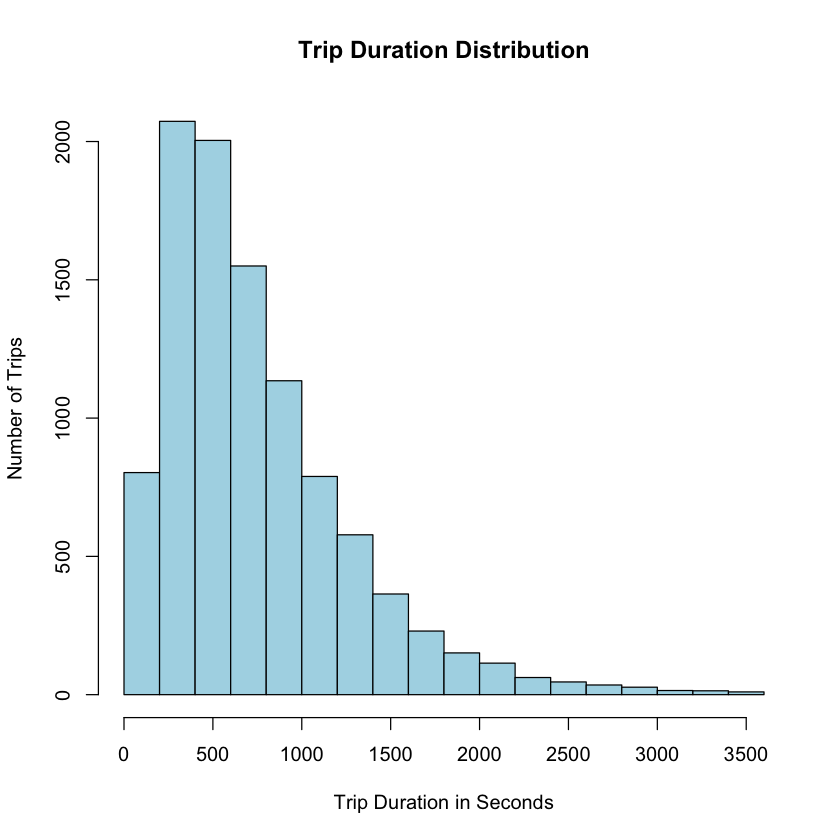

In [6]:
# Histogram
hist(trips$trip_duration, main="Trip Duration Distribution", 
  xlab="Trip Duration in Seconds",
  ylab="Number of Trips",
  col="lightblue")

# Tells us how many trips are in the dataset
paste("Trips in dataset:",nrow(trips))

### <p style="color:blue;font-weight: bold">Entities and Relationships</p>

In [7]:

# Create entityset
entities <- as_entityset(
  trips, 
  index = "id", 
  entity_id = "trips", 
  id = "trips", 
  time_index = "pickup_datetime"
) %>%
add_entity(
  pickup_neighborhoods, 
  entity_id = "pickup_neighborhoods", 
  index = "neighborhood_id"
) %>%
add_entity(
  dropoff_neighborhoods, 
  entity_id = "dropoff_neighborhoods", 
  index = "neighborhood_id"
)

# Add index relationships
entities <- entities %>%
add_relationship(
  parent_set = "pickup_neighborhoods", 
  child_set = "trips", 
  parent_idx = "neighborhood_id", 
  child_idx = "pickup_neighborhood"
)  %>%
  add_relationship(
    parent_set = "dropoff_neighborhoods", 
    child_set = "trips", 
    parent_idx = "neighborhood_id", 
    child_idx = "dropoff_neighborhood"
  ) 
print("Entities and Relationships generated")

[1] "Entities and Relationships generated"


## <u>1.1 First Model</u>

### <p style="color:blue;font-weight: bold">Transform Primitives</p>

In [8]:
trans_primitives <- c("is_weekend")
features <- dfs(
  entityset=entities,
  target_entity="trips",
  trans_primitives=trans_primitives,
  agg_primitives=NULL,
  ignore_variables= list(trips=c("pickup_latitude", "pickup_longitude",
                                 "dropoff_latitude", "dropoff_longitude", "trip_duration")),
  features_only=TRUE
)
print(paste("Number of features:",length(features)))

[1] "Number of features: 12"


### <p style="color:blue;font-weight: bold">Dataset Creation</p>

In [9]:
feature_matrix <- compute_features(features, entities)
head(feature_matrix,5)

[1] "Finishing computing..."


,vendor_id,passenger_count,trip_distance,payment_type,IS_WEEKEND(dropoff_datetime),IS_WEEKEND(pickup_datetime),pickup_neighborhoods.latitude,pickup_neighborhoods.longitude,dropoff_neighborhoods.latitude,dropoff_neighborhoods.longitude,⋯,dropoff_neighborhood = S,dropoff_neighborhood = AJ,dropoff_neighborhood = L,dropoff_neighborhood = M,dropoff_neighborhood = AF,dropoff_neighborhood = T,dropoff_neighborhood = B,dropoff_neighborhood = AI,dropoff_neighborhood = AE,dropoff_neighborhood = AQ
,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,1,2.46,1,TRUE,TRUE,40.75771,-73.98645,40.76681,-73.95689,⋯,0,0,0,0,0,0,0,0,0,0
2,1,2,7.90,1,TRUE,TRUE,40.74493,-73.91916,40.79360,-73.96982,⋯,0,0,0,0,0,0,0,0,0,0
3,1,1,1.00,1,TRUE,TRUE,40.72965,-73.99160,40.74033,-74.00511,⋯,0,0,0,0,0,0,0,0,0,0
4,2,1,0.02,2,TRUE,TRUE,40.72025,-73.98720,40.72025,-73.98720,⋯,0,0,0,0,0,0,0,0,0,0
5,1,2,19.00,1,TRUE,TRUE,40.64619,-73.78507,40.78500,-73.97605,⋯,0,0,0,0,0,0,0,0,0,0


### <p style="color:blue;font-weight: bold">Split dataset</p>

In [10]:
train_test = get_train_test_fm(feature_matrix, trips, .75)

y_train = log(train_test$y_train + 1)
y_test = log(train_test$y_test + 1)
X_train <- logical_to_integer(train_test$X_train)
X_test <- logical_to_integer(train_test$X_test)

trainingDataset = cbind(y_train,X_train)
print('Data split successful!')

[1] "Data split successful!"


### <p style="color:blue;font-weight: bold">Model 1.1: Fitting Generalized Boosted Regression Model</p>

In [11]:
gbm <- gbm(y_train  ~ ., data = trainingDataset,verbose = TRUE,
           n.trees = 100,
           distribution="gaussian",
           interaction.depth = 3,
           n.minobsinnode = 1,
           shrinkage = 0.1)

Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 5: `IS_WEEKEND(dropoff_datetime)` has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 6: `IS_WEEKEND(pickup_datetime)` has no variation.”


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.4800             nan     0.1000    0.0640
     2        0.4269             nan     0.1000    0.0512
     3        0.3842             nan     0.1000    0.0419
     4        0.3482             nan     0.1000    0.0362
     5        0.3168             nan     0.1000    0.0313
     6        0.2922             nan     0.1000    0.0250
     7        0.2711             nan     0.1000    0.0216
     8        0.2537             nan     0.1000    0.0174
     9        0.2395             nan     0.1000    0.0140
    10        0.2264             nan     0.1000    0.0124
    20        0.1620             nan     0.1000    0.0033
    40        0.1347             nan     0.1000    0.0003
    60        0.1287             nan     0.1000    0.0001
    80        0.1247             nan     0.1000    0.0000
   100        0.1208             nan     0.1000    0.0000



### <p style="color:blue;font-weight: bold">Model 1.1: Results from predictions</p>

<b>R^2</b>

In [12]:
predicted_gbm <- predict(gbm,X_test,n.trees = 100)
paste("R Squared:",round(r_squared(y_test,predicted_gbm),4))

[1] "R Squared: 0.6729"

### <p style="color:blue;font-weight: bold">Model 1.1: Feature influence</p>

In [13]:
head(round(relative.influence(gbm,sort= TRUE)/sum(relative.influence(gbm)),4),25)

n.trees not given. Using 100 trees.
n.trees not given. Using 100 trees.


trip_distance dropoff_neighborhoods.longitude 
                         0.9090                          0.0288 
 dropoff_neighborhoods.latitude  pickup_neighborhoods.longitude 
                         0.0233                          0.0062 
  pickup_neighborhoods.latitude      `dropoff_neighborhood = Z` 
                         0.0056                          0.0031 
    `dropoff_neighborhood = AA`                    payment_type 
                         0.0027                          0.0023 
    `dropoff_neighborhood = AU`       `pickup_neighborhood = D` 
                         0.0017                          0.0015 
     `pickup_neighborhood = AG`      `pickup_neighborhood = AR` 
                         0.0015                          0.0014 
     `pickup_neighborhood = AU`      `dropoff_neighborhood = E` 
                         0.0014                          0.0011 
    `dropoff_neighborhood = AC`      `pickup_neighborhood = AB` 
                         0.0011                          0.0010 
      `pickup_neighborhood = X`      `dropoff_neighborhood = H` 
                         0.0007                          0.0007 
    `dropoff_neighborhood = AO`      `dropoff_neighborhood = D` 
                         0.0007                          0.0006 
                      vendor_id      `pickup_neighborhood = AA` 
                         0.0006                          0.0006 
      `pickup_neighborhood = Z`      `dropoff_neighborhood = X` 
                         0.0005                          0.0005 
      `pickup_neighborhood = V` 
                         0.0005

## <u>1.2 Second Model</u>

### <p style="color:blue;font-weight: bold">Transform Primitives</p>

In [14]:
trans_primitives <- c("minute","day","week","month","weekday","is_weekend")
features <- dfs(
  entityset=entities,
  target_entity="trips",
  trans_primitives=trans_primitives,
  agg_primitives=NULL,
  ignore_variables= list(trips=c("pickup_latitude", "pickup_longitude",
                                 "dropoff_latitude", "dropoff_longitude", "trip_duration")),
  features_only=TRUE
)
print(paste("Number of features:",length(features)))

[1] "Number of features: 22"


### <p style="color:blue;font-weight: bold">Dataset Creation</p>

In [15]:
feature_matrix <- compute_features(features, entities)
head(feature_matrix,5)

[1] "Finishing computing..."


,vendor_id,passenger_count,trip_distance,payment_type,MINUTE(dropoff_datetime),MINUTE(pickup_datetime),DAY(dropoff_datetime),DAY(pickup_datetime),WEEK(dropoff_datetime),WEEK(pickup_datetime),⋯,dropoff_neighborhood = S,dropoff_neighborhood = AJ,dropoff_neighborhood = L,dropoff_neighborhood = M,dropoff_neighborhood = AF,dropoff_neighborhood = T,dropoff_neighborhood = B,dropoff_neighborhood = AI,dropoff_neighborhood = AE,dropoff_neighborhood = AQ
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,1,2.46,1,17,0,2,2,13,13,⋯,0,0,0,0,0,0,0,0,0,0
2,1,2,7.90,1,24,0,2,2,13,13,⋯,0,0,0,0,0,0,0,0,0,0
3,1,1,1.00,1,19,0,2,2,13,13,⋯,0,0,0,0,0,0,0,0,0,0
4,2,1,0.02,2,1,0,2,2,13,13,⋯,0,0,0,0,0,0,0,0,0,0
5,1,2,19.00,1,58,1,2,2,13,13,⋯,0,0,0,0,0,0,0,0,0,0


### <p style="color:blue;font-weight: bold">Split dataset</p>

In [16]:
train_test = get_train_test_fm(feature_matrix, trips, .75)

y_train = log(train_test$y_train + 1)
y_test = log(train_test$y_test + 1)
X_train <- logical_to_integer(train_test$X_train)
X_test <- logical_to_integer(train_test$X_test)

trainingDataset = cbind(y_train,X_train)
print('Data split successful!')

[1] "Data split successful!"


### <p style="color:blue;font-weight: bold">Model 1.2: Fitting Generalized Boosted Regression Model</p>

In [17]:
gbm <- gbm(y_train  ~ ., data = trainingDataset,verbose = TRUE,
           n.trees = 100,
           distribution="gaussian",
           interaction.depth = 3,
           n.minobsinnode = 1,
           shrinkage = 0.1)

Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 9: `WEEK(dropoff_datetime)` has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 10: `WEEK(pickup_datetime)` has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 11: `MONTH(dropoff_datetime)` has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 12: `MONTH(pickup_datetime)` has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 15: `IS_WEEKEND(dropoff_datetime)` has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 16: `IS_WEEKEND(pickup_datetime)` has no variation.”


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.4804             nan     0.1000    0.0633
     2        0.4271             nan     0.1000    0.0526
     3        0.3834             nan     0.1000    0.0419
     4        0.3474             nan     0.1000    0.0349
     5        0.3163             nan     0.1000    0.0307
     6        0.2910             nan     0.1000    0.0246
     7        0.2700             nan     0.1000    0.0208
     8        0.2524             nan     0.1000    0.0172
     9        0.2371             nan     0.1000    0.0150
    10        0.2241             nan     0.1000    0.0118
    20        0.1615             nan     0.1000    0.0034
    40        0.1344             nan     0.1000    0.0002
    60        0.1274             nan     0.1000   -0.0001
    80        0.1231             nan     0.1000    0.0000
   100        0.1204             nan     0.1000    0.0000



### <p style="color:blue;font-weight: bold">Model 1.2: Results from predictions</p>

<b>R^2</b>

In [18]:
predicted_gbm <- predict(gbm,X_test,n.trees = 100)
paste("R Squared:",round(r_squared(y_test,predicted_gbm),4))

[1] "R Squared: 0.7134"

### <p style="color:blue;font-weight: bold">Model 1.2: Feature influence</p>

In [19]:
head(round(relative.influence(gbm,sort= TRUE)/sum(relative.influence(gbm)),4),25)

n.trees not given. Using 100 trees.
n.trees not given. Using 100 trees.


trip_distance dropoff_neighborhoods.longitude 
                         0.9002                          0.0303 
 dropoff_neighborhoods.latitude  pickup_neighborhoods.longitude 
                         0.0187                          0.0145 
  pickup_neighborhoods.latitude      `MINUTE(dropoff_datetime)` 
                         0.0095                          0.0040 
    `dropoff_neighborhood = AA`         `DAY(dropoff_datetime)` 
                         0.0028                          0.0024 
         `DAY(pickup_datetime)`     `dropoff_neighborhood = AU` 
                         0.0022                          0.0019 
                   payment_type     `dropoff_neighborhood = AC` 
                         0.0018                          0.0017 
     `dropoff_neighborhood = E`      `dropoff_neighborhood = D` 
                         0.0012                          0.0010 
     `dropoff_neighborhood = H`      `pickup_neighborhood = AU` 
                         0.0008                          0.0008 
      `MINUTE(pickup_datetime)`                 passenger_count 
                         0.0007                          0.0007 
     `pickup_neighborhood = AB`       `pickup_neighborhood = D` 
                         0.0006                          0.0005 
     `pickup_neighborhood = AP`      `dropoff_neighborhood = X` 
                         0.0005                          0.0004 
     `pickup_neighborhood = AN`       `pickup_neighborhood = X` 
                         0.0004                          0.0004 
      `pickup_neighborhood = S` 
                         0.0003

## <u>1.3 Third Model</u>

### <p style="color:blue;font-weight: bold">Transform Primitives</p>

In [20]:
trans_primitives <- c("minute","day","week","month","weekday","is_weekend")
aggregation_primitives = c("count","sum","mean","median","std","max","min")
features <- dfs(
  entityset=entities,
  target_entity="trips",
  trans_primitives=trans_primitives,
  agg_primitives=aggregation_primitives,
  ignore_variables= list(trips=c("pickup_latitude", "pickup_longitude",
                                 "dropoff_latitude", "dropoff_longitude", "trip_duration")),
  features_only=TRUE
)
print(paste("Number of features:",length(features)))

[1] "Number of features: 72"


### <p style="color:blue;font-weight: bold">Dataset Creation</p>

In [21]:
feature_matrix <- compute_features(features, entities)
head(feature_matrix,5)

[1] "Finishing computing..."


,vendor_id,passenger_count,trip_distance,payment_type,MINUTE(dropoff_datetime),MINUTE(pickup_datetime),DAY(dropoff_datetime),DAY(pickup_datetime),WEEK(dropoff_datetime),WEEK(pickup_datetime),⋯,dropoff_neighborhood = S,dropoff_neighborhood = AJ,dropoff_neighborhood = L,dropoff_neighborhood = M,dropoff_neighborhood = AF,dropoff_neighborhood = T,dropoff_neighborhood = B,dropoff_neighborhood = AI,dropoff_neighborhood = AE,dropoff_neighborhood = AQ
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,1,2.46,1,17,0,2,2,13,13,⋯,0,0,0,0,0,0,0,0,0,0
2,1,2,7.90,1,24,0,2,2,13,13,⋯,0,0,0,0,0,0,0,0,0,0
3,1,1,1.00,1,19,0,2,2,13,13,⋯,0,0,0,0,0,0,0,0,0,0
4,2,1,0.02,2,1,0,2,2,13,13,⋯,0,0,0,0,0,0,0,0,0,0
5,1,2,19.00,1,58,1,2,2,13,13,⋯,0,0,0,0,0,0,0,0,0,0


### <p style="color:blue;font-weight: bold">Split dataset</p>

In [22]:
train_test = get_train_test_fm(feature_matrix, trips, .75)

y_train = log(train_test$y_train + 1)
y_test = log(train_test$y_test + 1)
X_train <- logical_to_integer(train_test$X_train)
X_test <- logical_to_integer(train_test$X_test)

trainingDataset = cbind(y_train,X_train)
print('Data split successful!')

[1] "Data split successful!"


### <p style="color:blue;font-weight: bold">Model 1.3: Fitting Generalized Boosted Regression Model</p>

In [23]:
gbm <- gbm(y_train  ~ ., data = trainingDataset,verbose = TRUE,
           n.trees = 100,
           distribution="gaussian",
           interaction.depth = 3,
           n.minobsinnode = 1,
           shrinkage = 0.1)

Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 9: `WEEK(dropoff_datetime)` has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 10: `WEEK(pickup_datetime)` has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 11: `MONTH(dropoff_datetime)` has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 12: `MONTH(pickup_datetime)` has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 15: `IS_WEEKEND(dropoff_datetime)` has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 16: `IS_WEEKEND(pickup_datetime)` has no variation.”
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
“variable 58: `drop

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.4821             nan     0.1000    0.0639
     2        0.4279             nan     0.1000    0.0525
     3        0.3840             nan     0.1000    0.0419
     4        0.3474             nan     0.1000    0.0356
     5        0.3178             nan     0.1000    0.0305
     6        0.2926             nan     0.1000    0.0255
     7        0.2720             nan     0.1000    0.0219
     8        0.2543             nan     0.1000    0.0170
     9        0.2389             nan     0.1000    0.0156
    10        0.2264             nan     0.1000    0.0130
    20        0.1608             nan     0.1000    0.0032
    40        0.1340             nan     0.1000    0.0003
    60        0.1261             nan     0.1000    0.0002
    80        0.1225             nan     0.1000   -0.0002
   100        0.1194             nan     0.1000   -0.0000



### <p style="color:blue;font-weight: bold">Model 1.3: Results from predictions</p>

<b>R^2</b>

In [24]:
predicted_gbm <- predict(gbm,X_test,n.trees = 100)
paste("R Squared:",round(r_squared(y_test,predicted_gbm),4))

[1] "R Squared: 0.7084"

### <p style="color:blue;font-weight: bold">Model 1.3: Feature influence</p>

In [25]:
head(round(relative.influence(gbm,sort= TRUE)/sum(relative.influence(gbm)),4),25)

n.trees not given. Using 100 trees.
n.trees not given. Using 100 trees.


trip_distance 
                                             0.9038 
                    dropoff_neighborhoods.longitude 
                                             0.0273 
                     dropoff_neighborhoods.latitude 
                                             0.0194 
    `pickup_neighborhoods.SUM(trips.trip_distance)` 
                                             0.0040 
   `dropoff_neighborhoods.SUM(trips.trip_distance)` 
                                             0.0032 
               `dropoff_neighborhoods.COUNT(trips)` 
                                             0.0024 
                                       payment_type 
                                             0.0024 
                      pickup_neighborhoods.latitude 
                                             0.0023 
                         `MINUTE(dropoff_datetime)` 
                                             0.0022 
 `pickup_neighborhoods.MEAN(trips.passenger_count)` 
                                             0.0022 
                `pickup_neighborhoods.COUNT(trips)` 
                                             0.0020 
                             `DAY(pickup_datetime)` 
                                             0.0020 
 `dropoff_neighborhoods.SUM(trips.passenger_count)` 
                                             0.0018 
   `pickup_neighborhoods.MEAN(trips.trip_distance)` 
                                             0.0017 
`dropoff_neighborhoods.MEAN(trips.passenger_count)` 
                                             0.0015 
      `dropoff_neighborhoods.MEAN(trips.vendor_id)` 
                                             0.0014 
                     pickup_neighborhoods.longitude 
                                             0.0014 
`dropoff_neighborhoods.MEDIAN(trips.trip_distance)` 
                                             0.0013 
       `pickup_neighborhoods.MEAN(trips.vendor_id)` 
                                             0.0012 
   `dropoff_neighborhoods.MAX(trips.trip_distance)` 
                                             0.0011 
       `dropoff_neighborhoods.SUM(trips.vendor_id)` 
                                             0.0010 
                          `pickup_neighborhood = X` 
                                             0.0010 
    `pickup_neighborhoods.STD(trips.trip_distance)` 
                                             0.0009 
                          `MINUTE(pickup_datetime)` 
                                             0.0009 
                        `dropoff_neighborhood = AA` 
                                             0.0008

## <u>Evaluate on Test Data</u>

In [26]:
y_pred <- predict(gbm,X_test,n.trees = 100)
y_pred <- exp(y_pred) - 1 # undo the log we took earlier

y_test <- train_test$y_test

print('y_pred and y_test computation successful!')

[1] "y_pred and y_test computation successful!"


In [27]:
# Print the first 5 predictions and real values
head(round(y_pred),10)
head(round(y_test),10)

[1]  495  773  744  737  516 1557  497 1184  790  620

[1]  357  570  520  519  390 1146  553 1050  603  599

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0   321.0   546.5   681.0   885.2  3573.0 

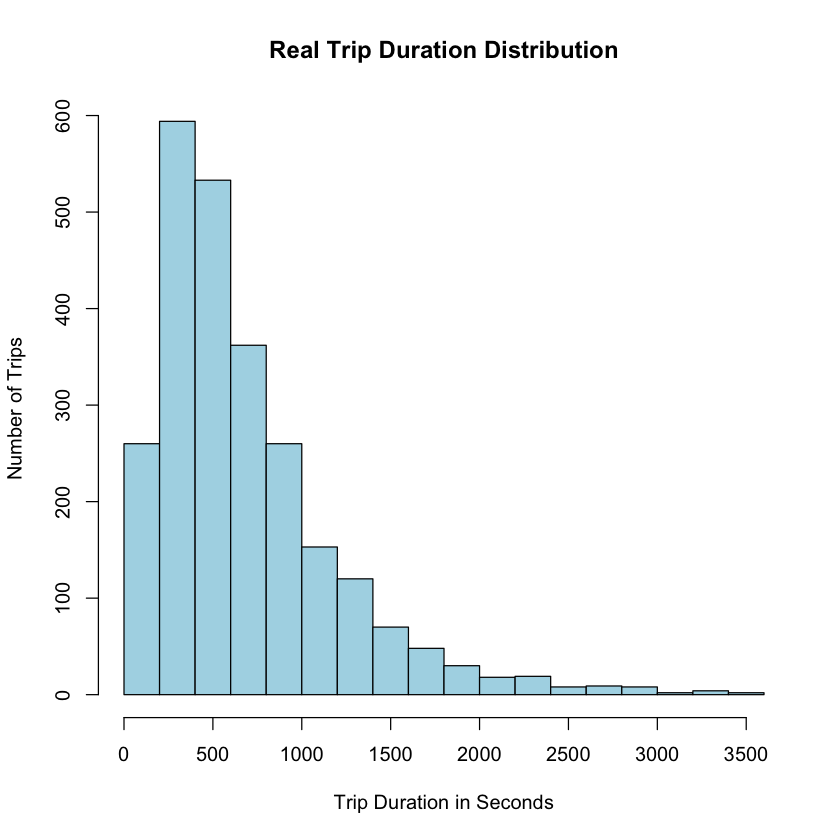

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15.14  363.23  591.37  706.21  948.33 2390.58 

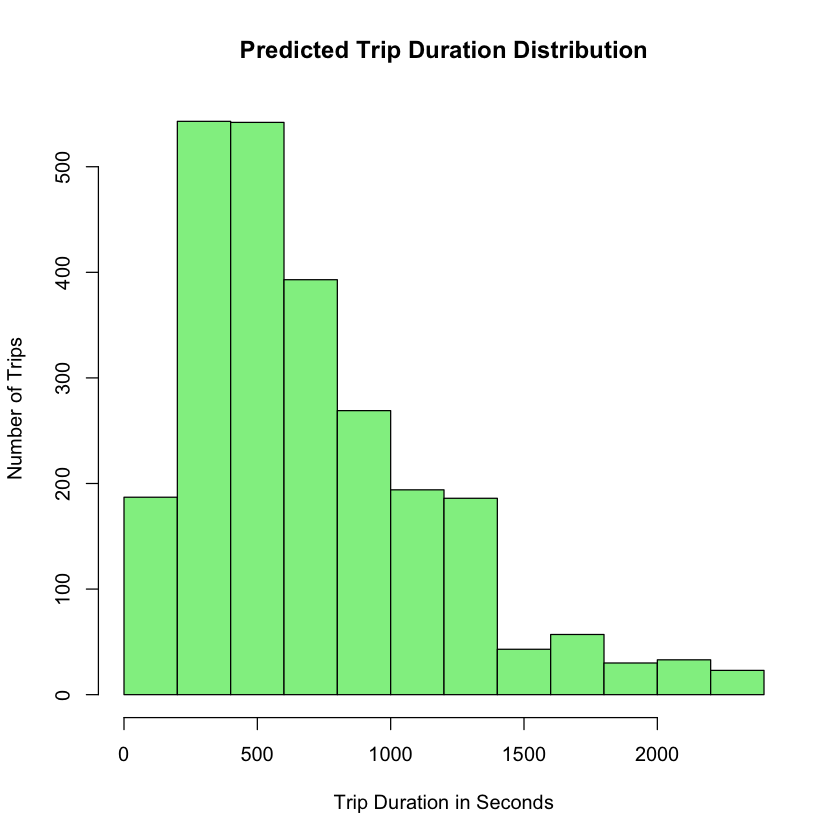

In [28]:
# Histogram of y_test
hist(y_test, main="Real Trip Duration Distribution", 
  xlab="Trip Duration in Seconds",
  ylab="Number of Trips",
  col="lightblue")
summary(y_test)

# Histogram of y_pred
hist(y_pred, main="Predicted Trip Duration Distribution", 
  xlab="Trip Duration in Seconds",
  ylab="Number of Trips",
  col="lightgreen")
summary(y_pred)